## Understanding BatchNorm with PyTorch Lightning: A Hands-on Tutorial


Batch Normalization (BatchNorm) is a powerful technique in deep learning that can significantly improve the training speed and performance of neural networks. In this tutorial, we'll explore BatchNorm using PyTorch Lightning, a high-level interface for PyTorch that simplifies the training process.

### What is BatchNorm?
BatchNorm normalizes the inputs to each layer in a neural network, which helps to reduce internal covariate shift. This normalization allows the network to use higher learning rates and be less sensitive to initialization, often leading to faster convergence and better overall performance.

### Setting up the environment

First, let's set up our environment and import the necessary libraries:


In [133]:
%load_ext autoreload
%autoreload 2

In [134]:
import sys
sys.path.insert(0, '/home/puneet/Projects/apply_llama3/src')

In [135]:
import os
import torch
from datasets import load_dataset

from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

from torch.utils.data import DataLoader
from torch import nn

from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.tuner import Tuner

import pandas as pd

### Local modules
from utils import print_metrics

### Preparing the dataset

We'll use the CIFAR-10 dataset for this tutorial. Let's load and prepare it:


In [27]:

# load cifar10 (only small portion for demonstration purposes) 
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']
     

In [28]:

image_mean, image_std = [0.5, 0.5, 0.5], [0.5,0.5,0.5]
size = 32

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [29]:

# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

Here, we're loading a subset of CIFAR-10 and applying data augmentation techniques like random cropping and horizontal flipping to the training set. The validation and test sets use a simpler transform without augmentation.

In [30]:
train_ds[0]['pixel_values'].shape

torch.Size([3, 32, 32])

### Creating DataLoaders

Next, we'll create DataLoaders to efficiently batch and shuffle our data:


In [31]:
batch_size = 128
NUM_WORKERS = int(os.cpu_count() / 2)

In [32]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}
    
def create_dataloaders(train_batch_size=64, eval_batch_size=64):
    train_dataloader = DataLoader(
        train_ds, shuffle=True, batch_size=train_batch_size, 
        collate_fn=collate_fn, num_workers=NUM_WORKERS
    )
    eval_dataloader = DataLoader(
        val_ds, shuffle=False, batch_size=eval_batch_size, 
        collate_fn = collate_fn, num_workers = NUM_WORKERS
    )
    return train_dataloader, eval_dataloader

This code sets up our DataLoaders with appropriate batch sizes and worker threads for efficient data loading.

In [33]:
train_dl, val_dl = create_dataloaders()

In [34]:
batch = next(iter(train_dl))

In [35]:
batch = next(iter(train_dl))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)
     

pixel_values torch.Size([64, 3, 32, 32])
labels torch.Size([64])


## Model

In [36]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

Now, let's define our model using PyTorch Lightning. We'll create a simple MLP (Multi-Layer Perceptron) with an option to include BatchNorm:

In [139]:
import lightning as L
import evaluate

class MLP(L.LightningModule):
    ''' multilayer perceptron'''
    def __init__(self, learning_rate=0.02,add_batchnorm=True):
        super().__init__()
        self.save_hyperparameters()
        if add_batchnorm:
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(32*32*3, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Linear(64,32),
                nn.BatchNorm1d(32),
                nn.ReLU(),
                nn.Linear(32, 10)
            )
        else:
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(32*32*3, 64),
                nn.ReLU(),
                nn.Linear(64,32),
                nn.ReLU(),
                nn.Linear(32, 10)
            )
        self.loss_fn = nn.CrossEntropyLoss()
        self.metrics = evaluate.load('accuracy')
        
    def forward(self, x):
        return self.layers(x)

    def shared_step(self, batch,batch_idx):
        x, y = batch['pixel_values'], batch['labels']
        logits = self(x)
        predictions = logits.argmax(dim=-1)
        loss = self.loss_fn(logits, y)
        # use add_batch if computing across batches
        acc = self.metrics.compute(references=y, predictions=predictions)
        return loss, acc['accuracy']

    def training_step(self, batch,batch_idx):
        loss, acc = self.shared_step(batch, batch_idx)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_accuracy', acc, prog_bar = True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.shared_step(batch, batch_idx)
        self.log('val_loss', loss, prog_bar = True)
        self.log('val_accuracy', acc, prog_bar = True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate, momentum=0.9)
        return optimizer
        

This model allows us to easily compare the performance with and without BatchNorm by setting the add_batchnorm parameter.

### Training the model

Let's set up our trainer and start training:

In [140]:
model = MLP(learning_rate=0.001, add_batchnorm=False)

trainer = L.Trainer(
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    logger=L.pytorch.loggers.CSVLogger(save_dir='logs/'),
		callbacks=EarlyStopping('val_loss', patience=3),

)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### LR Finder

/home/puneet/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/1000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LR finder stopped early after 710 steps due to diverging loss.
Learning rate set to 0.013396766874259348
Restoring states from the checkpoint path at /home/puneet/Projects/apply_llama3/src/random/.lr_find_baae0e22-dbc9-4d4e-b92c-66d917f8e986.ckpt
Restored all states from the checkpoint at /home/puneet/Projects/apply_llama3/src/random/.lr_find_baae0e22-dbc9-4d4e-b92c-66d917f8e986.ckpt
/tmp/ipykernel_71883/272602334.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


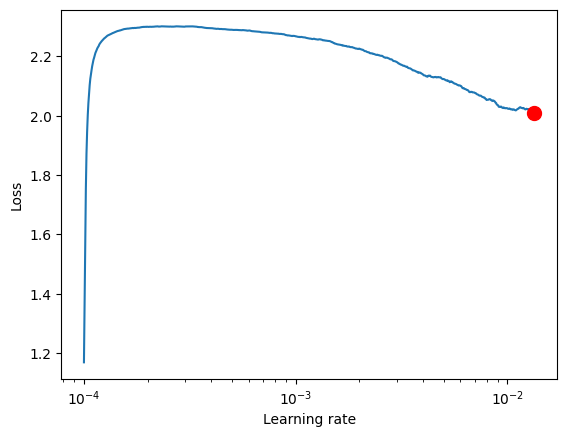

In [141]:
tuner = Tuner(trainer)
# Run learning rate finder
lr_finder = tuner.lr_find(model, train_dataloaders=train_dl, num_training=1000, min_lr = 0.0001, max_lr = 0.1 )
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

In [142]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
new_lr

0.013396766874259348

In [143]:
# update hparams of the model
model.hparams.learning_rate = new_lr

### Fit

In [144]:
trainer.fit(model, train_dl, val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | layers  | Sequential       | 199 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.796     Total estimated model params size (MB)


Sanity Checking: |                                                                    | 0/? [00:00<?, ?it/s]

Training: |                                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                         | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Result : With BatchNorm

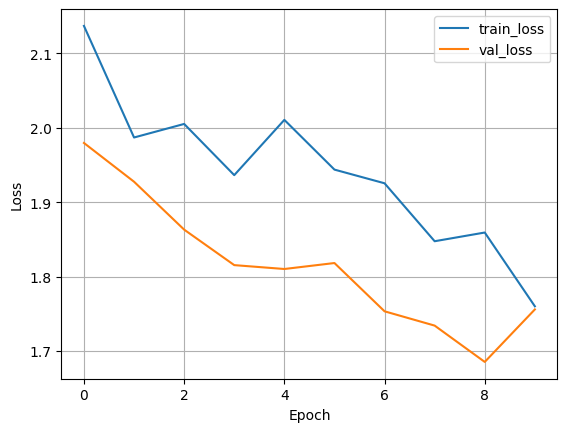

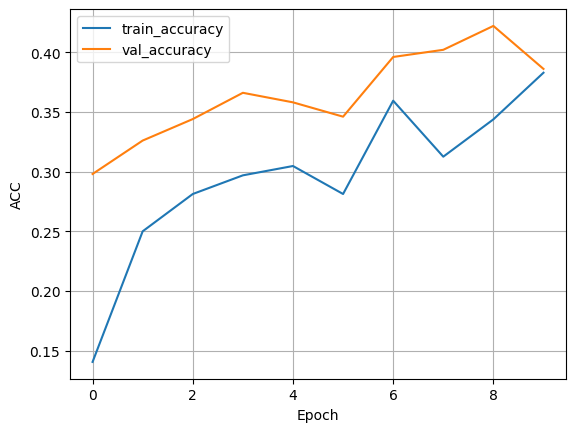

In [137]:
print_metrics(f"{trainer.logger.log_dir}/metrics.csv", save=True)

## Result: Without batchnorm

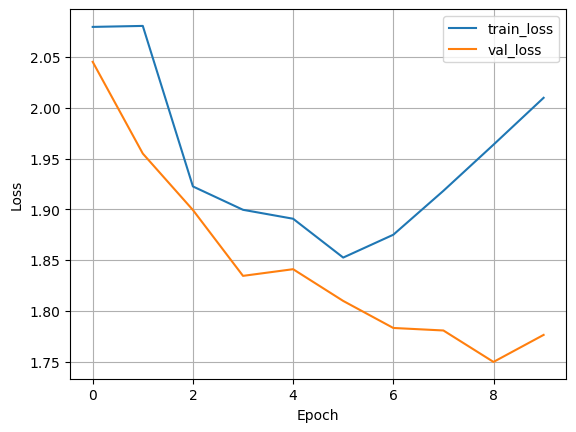

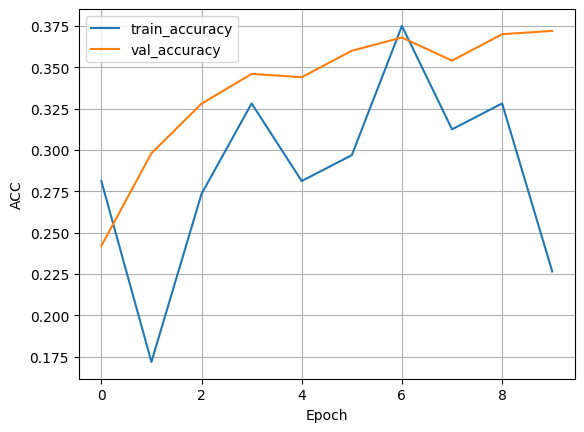

In [145]:
print_metrics(f"{trainer.logger.log_dir}/metrics.csv", save=True)

### Comparing with and without BatchNorm
To truly understand the impact of BatchNorm, we should run the training twice: once with BatchNorm and once without. Then we can compare the results.
When we run the model with BatchNorm (add_batchnorm=True), we typically see:

1. Faster convergence: The loss decreases more rapidly in the early epochs.
2. Higher final accuracy: The model often achieves a better final performance.
3. More stable training: The learning curves are often smoother.

Without BatchNorm (add_batchnorm=False), we might observe:

1. Slower convergence: It takes more epochs to reach the same level of performance.
2. Lower final accuracy: The model might not achieve as high a performance.
3. Less stable training: The learning curves might be more erratic.

### Conclusion

In this tutorial, we've explored how to implement and use BatchNorm in a PyTorch Lightning model. We've seen how to:

1. Prepare and load data using the CIFAR-10 dataset.
2. Create a simple MLP model with the option to include BatchNorm.
3. Use PyTorch Lightning for efficient model training.
4. Compare model performance with and without BatchNorm.

BatchNorm is a powerful technique that can significantly improve the training of deep neural networks. By normalizing the inputs to each layer, it allows for higher learning rates and reduces the dependence on careful initialization. This often leads to faster training and better overall performance.

Remember, while BatchNorm is often beneficial, its effectiveness can vary depending on the specific problem and model architecture. It's always a good idea to experiment and compare results with and without BatchNorm for your specific use case.
Happy coding and experimenting with BatchNorm!